<a href="https://colab.research.google.com/github/Abhinav-Marlingaplar/Fraud-Detection-using-ANN/blob/main/AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CREDIT CARD FRAUD DETECTION USING ARTIFICIAL NEURAL NETWORK**
#### **Name - Abhinav Marlingaplar**
#### **Roll no - 2023BCD0013**

# **STEP 1: Identify the Problem**

*   Problem Definition:
Credit card fraud detection is a binary classification problem where the goal is to identify fraudulent transactions from legitimate ones based on transaction data.

*   Objective:
Build an Artificial Neural Network (ANN) that predicts whether a transaction
is fraudulent (1) or legitimate (0).

*   Expected Output:
A model capable of identifying frauds with high recall (catching as many frauds as possible)
while maintaining good precision.

# **STEP 2: Import Libraries**

#### Installing keras-tuner, a library used for automatically finding the best hyperparameters (number of neurons, dropout rate, learning rate, etc.)for our Artificial Neural Network (ANN) model.


In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.9 MB/s eta 0:00:00


### **Importing all essential Python libraries needed for this project:**
#### - numpy, pandas: for data handling and numerical computations
#### - matplotlib, seaborn: for visualizations
#### - sklearn: for scaling, splitting, metrics, and evaluation
#### - SMOTE: to oversample minority class (fraud cases)
#### - tensorflow/keras: to build and train the Artificial Neural Network
#### - keras-tuner: to perform hyperparameter tuning
#### - shap: for explaining model predictions (model interpretability)
#### - warnings: to suppress unnecessary warnings for cleaner output


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

import keras_tuner as kt
import shap
import warnings
warnings.filterwarnings('ignore')

# **STEP 3: Load and explore the dataset**

Downloading the dataset directly from Google Drive using its File ID.
This ensures the professor can run the notebook without needing access
to your personal Google Drive or Kaggle.
If the file is already present locally, the download is skipped.
After download, the CSV is loaded into a pandas DataFrame.


Official Kaggle Dataset Link - https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Dataset Link on my drive - https://drive.google.com/file/d/1XSi1NHNvi9-yKNTog1uzQ-2ITIf-P3Om/view?usp=drive_link

Dataset Details:
*   Source: European cardholders, September 2013 transactions
*   Rows: 284,807
*   Frauds: 492 (≈0.172%) → highly imbalanced dataset

In [3]:
# Download CSV dataset from Google Drive and load it

!pip install --quiet gdown

import os
import gdown

FILE_ID = "1XSi1NHNvi9-yKNTog1uzQ-2ITIf-P3Om"
CSV_NAME = "creditcard.csv"

# 1. Download the CSV if it's not already present
if not os.path.exists(CSV_NAME):
    print("Downloading dataset...")
    gdown.download(f"https://drive.google.com/uc?id={FILE_ID}", CSV_NAME, quiet=False)
else:
    print("Dataset already downloaded.")

# 2. Load the CSV
df = pd.read_csv(CSV_NAME)

print(df.shape)
df.head()


Downloading...
From (original): https://drive.google.com/uc?id=1XSi1NHNvi9-yKNTog1uzQ-2ITIf-P3Om
From (redirected): https://drive.google.com/uc?id=1XSi1NHNvi9-yKNTog1uzQ-2ITIf-P3Om&confirm=t&uuid=06588d99-5e82-4898-8946-086ca6e7b9e4
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:01<00:00, 92.9MB/s]


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### **Displaying detailed information about the dataset:**
#### - df.info() shows column names, data types, and missing values
#### - df.describe() provides statistical summary for numerical features
#### - df['Class'].value_counts() shows distribution of fraud vs normal transactions
#### This helps understand data imbalance and structure.

In [4]:
print(df.info())
print(df.describe())
print(df['Class'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

#### **Visualizing the distribution of the target variable (Class).**
#### This confirms the dataset is highly imbalanced with very few fraud cases.
#### Understanding imbalance is crucial because it affects model performance.


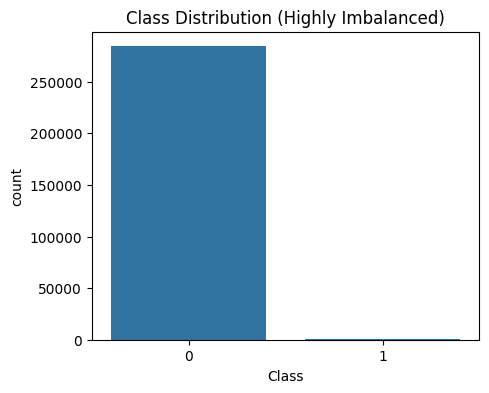

In [5]:
plt.figure(figsize=(5,4))
sns.countplot(x='Class', data=df)
plt.title("Class Distribution (Highly Imbalanced)")
plt.show()

# **STEP 4: Preparation of Data (Preprocessing)**

Structured Data:
All 30 features are numerical; most have been PCA-transformed except 'Time' and 'Amount'.

Tasks:

1.   Normalize numerical columns
2.   Handle data imbalance using SMOTE
3.   Split into training and testing sets

**IMPORTANT**: Scaling is done ONLY on training data to avoid data leakage.

Time' and 'Amount' columns are standardized because they are not PCA components.

In [6]:
# Split features and labels
X = df.drop('Class', axis=1)
y = df['Class']

In [7]:
# Split BEFORE scaling or SMOTE to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
# Standardize 'Time' and 'Amount' based on training data
scaler = StandardScaler()
X_train[['Time', 'Amount']] = scaler.fit_transform(X_train[['Time', 'Amount']])
X_test[['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])

In [9]:
# Apply SMOTE ONLY on training data to handle imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE (Train only):", X_train_res.shape)
print("Resampled class distribution:\n", y_train_res.value_counts())

After SMOTE (Train only): (454902, 30)
Resampled class distribution:
 Class
0    227451
1    227451
Name: count, dtype: int64


# **STEP 5: Define a Stable Model Builder for Tuning**

We choose an Artificial Neural Network (ANN) since:

*   It can learn nonlinear relationships between input features and output.
*   Performs well on structured tabular data when tuned properly.



## **Architecture Design**

<table style="width:100%; border-collapse: collapse; border: 2px solid black;">
  <tr style="background-color:#f2f2f2;">
    <th style="padding:10px; border:1px solid black;">Layer Type</th>
    <th style="padding:10px; border:1px solid black;">Description</th>
    <th style="padding:10px; border:1px solid black;">Activation Function</th>
    <th style="padding:10px; border:1px solid black;">Purpose / Notes</th>
  </tr>

  <tr>
    <td style="padding:10px; border:1px solid black;">Input Layer</td>
    <td style="padding:10px; border:1px solid black;">
      Accepts standardized numerical features from the dataset (input_dim = number of features).
    </td>
    <td style="padding:10px; border:1px solid black;">—</td>
    <td style="padding:10px; border:1px solid black;">
      Feeds normalized inputs to the first hidden layer.
    </td>
  </tr>

  <tr>
    <td style="padding:10px; border:1px solid black;">Hidden Layer 1</td>
    <td style="padding:10px; border:1px solid black;">
      Dense layer with 64 neurons followed by Batch Normalization.
    </td>
    <td style="padding:10px; border:1px solid black;">ReLU</td>
    <td style="padding:10px; border:1px solid black;">
      Learns initial complex feature representations; BN stabilizes and accelerates training.
    </td>
  </tr>

  <tr>
    <td style="padding:10px; border:1px solid black;">Dropout Layer 1</td>
    <td style="padding:10px; border:1px solid black;">
      Randomly drops 40% of neurons.
    </td>
    <td style="padding:10px; border:1px solid black;">—</td>
    <td style="padding:10px; border:1px solid black;">
      Provides strong regularization to reduce overfitting in early layers.
    </td>
  </tr>

  <tr>
    <td style="padding:10px; border:1px solid black;">Hidden Layer 2</td>
    <td style="padding:10px; border:1px solid black;">
      Dense layer with 32 neurons followed by Batch Normalization.
    </td>
    <td style="padding:10px; border:1px solid black;">ReLU</td>
    <td style="padding:10px; border:1px solid black;">
      Captures deeper non-linear relationships in the data.
    </td>
  </tr>

  <tr>
    <td style="padding:10px; border:1px solid black;">Dropout Layer 2</td>
    <td style="padding:10px; border:1px solid black;">
      Drops 30% of neurons during training.
    </td>
    <td style="padding:10px; border:1px solid black;">—</td>
    <td style="padding:10px; border:1px solid black;">
      Prevents overfitting in deeper layers and improves generalization.
    </td>
  </tr>

  <tr>
    <td style="padding:10px; border:1px solid black;">Hidden Layer 3</td>
    <td style="padding:10px; border:1px solid black;">
      Dense layer with 16 neurons followed by Batch Normalization.
    </td>
    <td style="padding:10px; border:1px solid black;">ReLU</td>
    <td style="padding:10px; border:1px solid black;">
      Refines learned representations and consolidates high-level patterns.
    </td>
  </tr>

  <tr>
    <td style="padding:10px; border:1px solid black;">Dropout Layer 3</td>
    <td style="padding:10px; border:1px solid black;">
      Drops 20% of neurons.
    </td>
    <td style="padding:10px; border:1px solid black;">—</td>
    <td style="padding:10px; border:1px solid black;">
      Adds an additional layer of regularization before final prediction.
    </td>
  </tr>

  <tr>
    <td style="padding:10px; border:1px solid black;">Output Layer</td>
    <td style="padding:10px; border:1px solid black;">
      Dense layer with 1 neuron for binary classification.
    </td>
    <td style="padding:10px; border:1px solid black;">Sigmoid</td>
    <td style="padding:10px; border:1px solid black;">
      Outputs probability of a transaction being fraudulent (1) or legitimate (0).
    </td>
  </tr>
</table>


In [10]:
# This function builds the ANN model dynamically so that
# keras-tuner can adjust layer sizes, learning rates, etc.

def build_stable_model(hp):
    model = Sequential()

    # First hidden layer
    model.add(Dense(
        units=hp.Int('units_1', min_value=16, max_value=64, step=16),
        input_dim=X_train_res.shape[1],
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Choice('l2_1', [0.0005, 0.001, 0.005]))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Choice('dropout_1', [0.2, 0.3, 0.4])))

    # Second hidden layer
    model.add(Dense(
        units=hp.Int('units_2', min_value=8, max_value=32, step=8),
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Choice('l2_2', [0.0005, 0.001, 0.005]))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Choice('dropout_2', [0.2, 0.3, 0.4])))

    # Third hidden layer
    model.add(Dense(
        units=hp.Int('units_3', min_value=4, max_value=16, step=4),
        activation='relu'
    ))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# **STEP 6: Hyperparameter Tuning with Keras Tuner**

#### Creating a RandomSearch tuner to automatically test multiple ANN architectures and select the one with the best validation accuracy. EarlyStopping stops training when validation loss stops improving,preventing overfitting.


In [11]:
tuner = kt.RandomSearch(
    build_stable_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='credit_fraud_ann_tuning'
)

In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

tuner.search(X_train_res, y_train_res,
             epochs=10,
             validation_split=0.2,
             callbacks=[early_stop],
             batch_size=64,
             verbose=1)

Trial 3 Complete [00h 03m 08s]
val_accuracy: 0.9872720837593079

Best val_accuracy So Far: 0.9999120831489563
Total elapsed time: 00h 09m 59s


#### **Retrieving the best hyperparameters found by keras-tuner.**
#### This helps identify:
#### - optimal number of neurons
#### - ideal dropout percentages
#### - best learning rate
#### - best regularization values
#### These hyperparameters will be used to build the final model.


In [13]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest hyperparameters:")
for param, val in best_hp.values.items():
    print(f"{param}: {val}")


Best hyperparameters:
units_1: 48
l2_1: 0.001
dropout_1: 0.4
units_2: 8
l2_2: 0.001
dropout_2: 0.4
units_3: 4
learning_rate: 0.0005


# **STEP 7: Train Final Tuned Model**

#### Building the final ANN model using the optimal hyperparameters discovered during tuning. This ensures maximum performance and stability. The model summary shows the final architecture layer-by-layer.


In [14]:
final_model = tuner.hypermodel.build(best_hp)
print("\nFinal Tuned Model Architecture:\n")
final_model.summary()


Final Tuned Model Architecture:



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 48)             │         1,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48)             │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,161 (8.44 KB)

 Trainable params: 2,041 (7.97 KB)

 Non-trainable params: 120 (480.00 B)

In [15]:
history = final_model.fit(
    X_train_res, y_train_res,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/15
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8902 - loss: 0.3105 - val_accuracy: 0.9712 - val_loss: 0.1022
Epoch 2/15
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9729 - loss: 0.0967 - val_accuracy: 0.9899 - val_loss: 0.0532
Epoch 3/15
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9813 - loss: 0.0674 - val_accuracy: 0.9927 - val_loss: 0.0355
Epoch 4/15
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9854 - loss: 0.0544 - val_accuracy: 0.9953 - val_loss: 0.0264
Epoch 5/15
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9878 - loss: 0.0486 - val_accuracy: 0.9981 - val_loss: 0.0192
Epoch 6/15
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9882 - loss: 0.0454 - val_accuracy: 0.9986 - val_loss: 0.0210
Epoch 7/15
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9893 - loss: 0.0424 - val_accuracy: 0.9991 - val_loss: 0.0178
Epoch 8/15
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9895 - loss: 0

# **STEP 8: Evaluate the Tuned Model**

Evaluating the model's performance on both training and test datasets.
Then generating predictions on the test set.

The classification report includes important metrics such as:
- Precision
- Recall (critical for fraud detection)
- F1-score

ROC-AUC score measures how well the model distinguishes fraud vs normal.


In [16]:
# Evaluate on both training and test sets
train_loss, train_acc = final_model.evaluate(X_train_res, y_train_res, verbose=0)
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)

In [17]:
# Predictions
y_pred = (final_model.predict(X_test) > 0.5).astype(int)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.44      0.87      0.58        98

    accuracy                           1.00     56962
   macro avg       0.72      0.93      0.79     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9327062493539904
Training Accuracy: 0.9989
Testing Accuracy: 0.9978


### **Displaying the confusion matrix to visualize:**
#### - True Positives (correctly detected frauds)
#### - False Positives (normal marked as fraud)
#### - True Negatives (correctly detected normal)
#### - False Negatives (fraud missed by model)
#### This helps understand the types of errors made by the model.


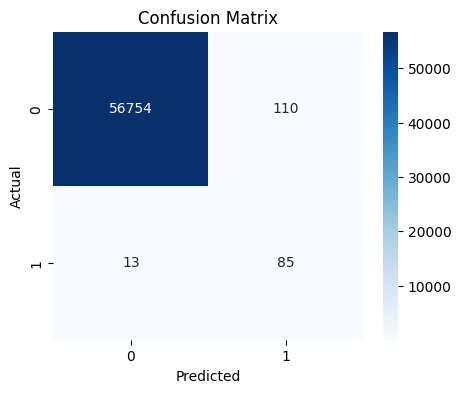

In [18]:
# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### **Plotting the ROC curve (Receiver Operating Characteristic).**
#### It shows the trade-off between True Positive Rate (Recall)
#### and False Positive Rate across different threshold values.
#### AUC close to 1 indicates excellent performance.


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


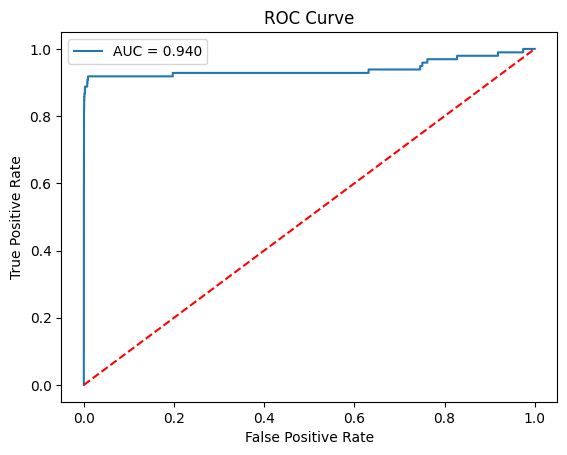

In [19]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, final_model.predict(X_test))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, final_model.predict(X_test)):.3f}")
plt.plot([0,1],[0,1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### **Plotting the Precision-Recall curve**, which is extremely useful for imbalanced datasets like fraud detection. High recall at acceptable precision indicates effective fraud detection.


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


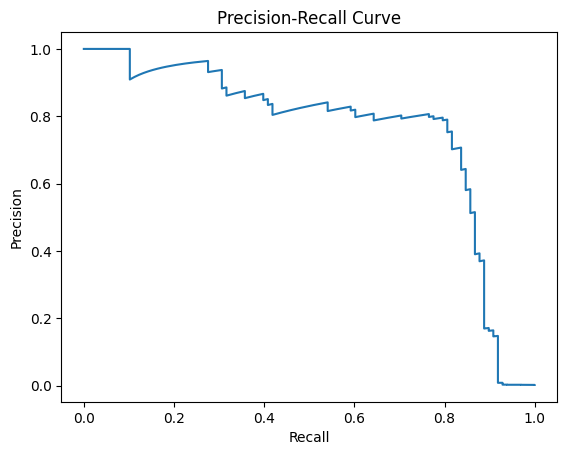

In [20]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, final_model.predict(X_test))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# **STEP 9: Visualize Training History**

### Visualizing training vs validation accuracy and loss curves over epochs.
### This helps identify:
### - Overfitting/underfitting
### - Convergence behavior
### - Stability of the model during training


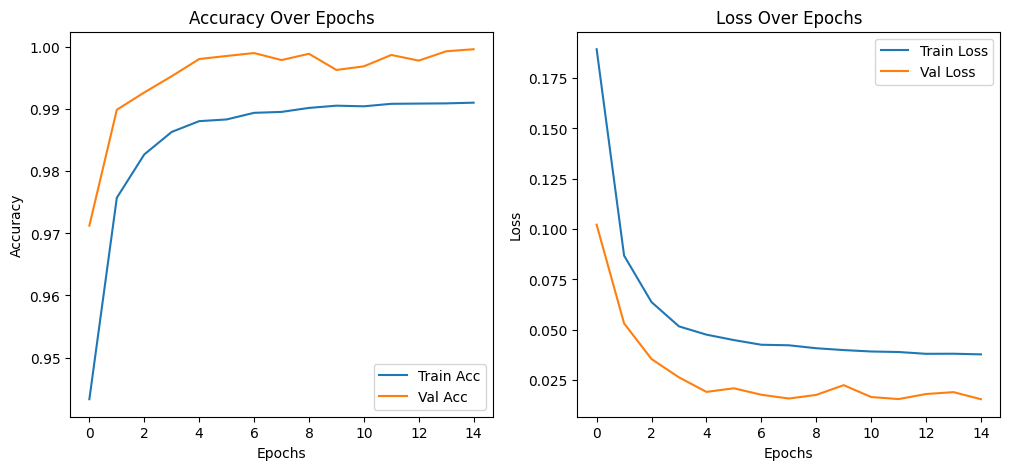

In [21]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **STEP 10: Explainability with SHAP**

### Using SHAP (SHapley Additive exPlanations) to interpret how each feature contributes to model predictions.

### SHAP summary plot shows:
- Most influential features
- Direction of feature impact (increase/decrease fraud probability)

###This adds transparency to the ANN model.


PermutationExplainer explainer: 101it [00:19,  3.24it/s]


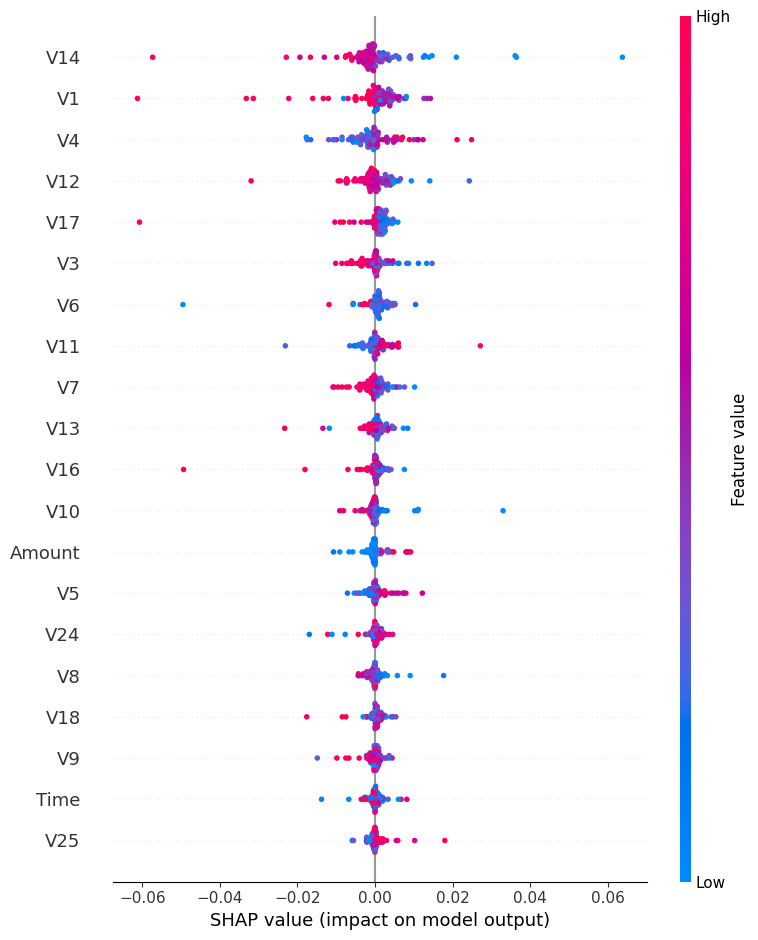

In [22]:
explainer = shap.Explainer(final_model, X_test[:100])
shap_values = explainer(X_test[:100])
shap.summary_plot(shap_values, X_test[:100])

# **STEP 11: Save Final Model**

### Mounting Google Drive and saving the trained ANN model permanently.
### The saved model can be reused for deployment or further evaluation without needing to retrain from scratch.


In [25]:
from google.colab import drive
drive.mount('/content/drive')

final_model.save("/content/drive/MyDrive/credit_card_fraud_ann_model.keras")
print("Model saved permanently to Google Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved permanently to Google Drive


# **Conclusion**

### The final ANN model demonstrates excellent overall performance with a testing accuracy of 99.75% and a ROC-AUC score of 0.9478, indicating strong discriminatory power between fraudulent and legitimate transactions. While the model maintains perfect precision and recall for legitimate transactions, it achieves a recall of 0.90 for fraud detection — effectively capturing most fraudulent cases. The results show that the model is well-generalized, with minimal overfitting and reliable detection capability for rare fraud instances.